# Intro

This is for preprocess dataset. There are steps we have:

## Audio preprocess

1. convert audios from wave to mel_spectrogram
2. convert audios from wave to spectrogram
3. globally normalize (mel-)spectrogram
4. filter sound then do transformation

## Load subset from entire dataset (for Frank)

In [ ]:
import pandas as pd
from librosa.util import index_to_slice
from scipy.signal import spectrogram

# meta data file (with syllable information)
import DataLoader as dl
import audioPreprocess as ap
import random
import dataPreprocess as dp

metafile = 'guide_test_syllableInfor.pkl'
datanum = 10000 # assume that you want 10000 tokens

In [ ]:

suids,padded_waves = dp.load_dataset('/mnt/storage/compling/proslearn/src/eng/guide_test_waves_padded.pkl')

In [ ]:
loader = dl.DataLoader()
meta = loader.get_metadata(metafile)

In [ ]:
# you may randomly select certain number of data
mels,indexes = loader.load_data('mel',datanum)
spectrograms = loader.load_data('spectrogram',datanum,indexes)[0]
soundpaths = [meta['filepath'][i] for i in indexes]

In [ ]:
# or you can get a bunch of indexlists that keeps the original distribution first
meta['index'] = meta.index
indexset = meta[['stress_type','index','suid']]
# Split into subsets
subsets_index = dp.split_into_subsets(indexset, num_subsets=50, sortkey='stress_type')
# #Display the resulting subsets
# for i, subset in enumerate(subsets):
#     dp.checkDistribution(subset['stress_type'])

In [ ]:
seed = random.randint(0,datanum)
index = indexes[seed]
word = meta['word'][index]
syllble = meta['syllable'][index]
suid = meta['suid'][index]
stress_type = meta['stress_type'][index]
print(f'word:{word}; syllable: {syllble}; stress_type:{stress_type}; suid:{suid}')
sound,sr = ap.load_file(meta['filepath'][index])
ap.visualize_waveform(sound,sr)
padded = padded_waves[index]
ap.visualize_waveform(padded,sr)
ap.visualize_mel(mels[seed])
ap.visualize_spectrogram(spectrograms[seed])

# Normalization Pretest 
(not need to run this)


In [ ]:
import numpy as np

# Parameters
sample_rate = 16000  # Samples per second
duration = 0.25       # Duration in seconds
frequency = 1000     # Frequency of the tone in Hertz

# Generate the time axis
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
# Generate the audio signal (sine wave)
audio_signal = np.sin(2 * np.pi * frequency * t)
audio_signal /= np.max(np.abs(audio_signal))  # This ensures max amplitude is 1
#silence = np.zeros(int(sample_rate * duration))+2e-5

padded_waves += [audio_signal]

## check ceiling and floor for spectrogram

In [ ]:
chunk_size = 5000
max_dB = None
min_dB = None
# Process in chunks
for start in range(0, len(padded_waves), chunk_size):
    end = min(start + chunk_size, len(padded_waves))
    chunk = padded_waves[start:end]
    # Convert the chunk
    chunk_spectrogram = [ap.wav_to_spectrogram(sound) for sound in chunk]
    chunk_spectrogram = np.array(chunk_spectrogram)
    chunk_max = np.max(chunk_spectrogram)
    chunk_min = np.min(chunk_spectrogram)
    if max_dB is None or chunk_max > max_dB:
        max_dB = chunk_max
    if min_dB is None or chunk_min < min_dB:
        min_dB = chunk_min
print(max_dB,'   ', min_dB)

#based on test dataset, max dB for spectrogram is 147.28614807128906, min is -6.0206074714660645

## check ceiling and floor for mel spectrogram

In [ ]:
chunk_size = 5000
max_dB = None
min_dB = None
# Process in chunks
for start in range(0, len(padded_waves), chunk_size):
    end = min(start + chunk_size, len(padded_waves))
    chunk = padded_waves[start:end]
    # Convert the chunk
    chunk_spectrogram = [ap.wav_to_mel_spectrogram(sound) for sound in chunk]
    chunk_spectrogram = np.array(chunk_spectrogram)
    chunk_max = np.max(chunk_spectrogram)
    chunk_min = np.min(chunk_spectrogram)
    if max_dB is None or chunk_max > max_dB:
        max_dB = chunk_max
    if min_dB is None or chunk_min < min_dB:
        min_dB = chunk_min
print(max_dB,'   ', min_dB)
#based on test dataset, max dB for mel spectrogram is 128.88963741610183, min is -6.0206074714660645

# Task for Shuhao

1. filter padded_waves (high&low) and save filtered waveforms as pkl files (_lowpass.pkl & _highpass.pkl)
2. convert filtered waves to spectrogram and mel-spectrogram, save converted data to .npy under folders 'low_spectrograms', 'high_spectrograms', 'low_mel',and 'hgih_mel'
3. repeat the whole process for guide_train.csv and guide_validation.csv

Note: 
1. please do not rerun the code for processing unfilltered sounds in guide_test.csv, try them with other csvs to avoid damaging processed data (I commented out those chunks)
2. There's no new method that you need to develop, unless you find some problems, if so, talk to us first. Basically, what you need to do is to learn the preprocess procudure and replicate it. 



# Meta Data process

## import packages

In [2]:
import os
import numpy as np
import audioPreprocess as ap
import random
import dataPreprocess as dp

## set parameters

In [4]:
## there are three csv files that need to be processed; guide_train.csv, guide_test.csv,guide_validation.csv
soundfolder = '/mnt/storage/compling/proslearn/src/eng/train-clean-100-cs' # where original sound files are stored
test_csvpath = r'/mnt/storage/compling/proslearn/src/eng/guide_train.csv'  

## define result files' names
meta_path = test_csvpath.replace('.csv','_syllableInfor.pkl')
waves_path = test_csvpath.replace('.csv','_waves.pkl')
padded_waves_path = test_csvpath.replace('.csv','_waves_padded.pkl')
lowpass_waves_path = test_csvpath.replace('.csv','_waves_lowpass.pkl')
highpass_waves_path = test_csvpath.replace('.csv','_waves_highpass.pkl')
spectrogram_folder = soundfolder.replace('train-clean-100-cs','spectrograms')
os.makedirs(spectrogram_folder, exist_ok=True)
mel_folder = soundfolder.replace('train-clean-100-cs','mels')
os.makedirs(mel_folder, exist_ok=True)
lowpass_spectrogram_folder = soundfolder.replace('train-clean-100-cs','lowpass_spectrograms')
os.makedirs(lowpass_spectrogram_folder, exist_ok=True)
highpass_spectrogram_folder = soundfolder.replace('train-clean-100-cs','highpass_spectrograms')
os.makedirs(highpass_spectrogram_folder, exist_ok=True)
lowpass_mel_folder = soundfolder.replace('train-clean-100-cs','lowpass_mels')
os.makedirs(lowpass_mel_folder, exist_ok=True)
highpass_mel_folder = soundfolder.replace('train-clean-100-cs','highpass_mels')
os.makedirs(highpass_mel_folder, exist_ok=True)

In [5]:
spec_max_dB = 147.28614807128906 
spec_min_dB =  -6.0206074714660645
mel_max_dB = 128.88963741610183
mel_min_dB = -6.0206074714660645

## modify meta data

In [6]:
# load csv
test_data = dp.load_csv(test_csvpath)

In [7]:
# generate syllable based dataframe
# test_data.columns
selectcols = ['word', 'stress_type','syllable', 'syllable_id',
       'syllable_startTime', 'syllable_endTime',
       'syllable_path', 'suid']
test_data = test_data[selectcols]

In [9]:
# remove SNA stress_type
test_data = test_data[test_data['stress_type'] != 'SNA']

In [ ]:
# remove duplicated rows
test_data = test_data.drop_duplicates(ignore_index=True)

In [10]:
test_data['filepath'] = test_data['syllable_path'].apply(lambda x: os.path.join(soundfolder, x))
print('Before dropping: ',test_data.shape)

Before dropping:  (1078683, 9)


In [11]:
# drop rows where the sound file doesn't exist
test_data = test_data[test_data['filepath'].apply(lambda x: os.path.exists(x))]
test_data.reset_index(drop=True, inplace=True)
print('After dropping: ',test_data.shape)

After dropping:  (1078680, 9)


## save modified meta data

In [12]:
dp.save_dataset(test_data,meta_path)

# Audio process

## get sample rate

In [13]:
test_data = dp.load_dataset(meta_path)

In [14]:
sound, sr = ap.load_file(test_data['filepath'][0])

## load all audio files 

In [15]:
waves = [ap.load_file(file)[0] for file in test_data['filepath']]
print(len(waves))

1078680


## waveforms

### unpadded waves

In [ ]:
# # save unpadded waves
# dp.save_dataset(waves,waves_path) # a list is saved

### padded waves

In [16]:
def padder_waveform(sound, sample_rate=16000, pad_len_ms=250, noise_level=0.001) -> np.ndarray:
    '''
    Random pad a waveform (mono) to fixed length
    :param sound: waveform
    :param sample_rate:
    :param pad_len_ms: target length of padded waveform
    :param noise_level: the sound will be padded with noise
    :return: padded waveform
    '''
    pad_len_frame = sample_rate // 1000 * pad_len_ms
    sound_len = len(sound)
    if sound_len > pad_len_frame:
        try:
            sig = sound[:pad_len_frame]
        except:
            print(sound)
            print(pad_len_frame)
            input()

    elif sound_len < pad_len_frame:
        # Length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, pad_len_frame - sound_len)
        pad_end_len = pad_len_frame - sound_len - pad_begin_len

        # Pad with 0s
        # pad_begin = torch.zeros((num_rows, pad_begin_len))
        # pad_end = torch.zeros((num_rows, pad_end_len))
        pad_begin = np.random.randn(pad_begin_len) * noise_level
        pad_end = np.random.randn(pad_end_len) * noise_level

        sig = np.concatenate((pad_begin, sound, pad_end))
    else:
        sig =sound
    return sig

In [17]:
# pad waves
padded_waves = [padder_waveform(wave,sample_rate=sr,pad_len_ms=250,noise_level=1e-4) for wave in waves]

In [18]:
suids = list(test_data['suid'])

In [19]:
# save pad waves
dp.save_dataset((suids,padded_waves),padded_waves_path) # a list is saved

In [20]:
del waves

## waveform to (mel-)spectrogram
### convert to spectrogram

In [7]:
#load padded wave
suids,padded_waves = dp.load_dataset(padded_waves_path)

is
IH0 Z
0


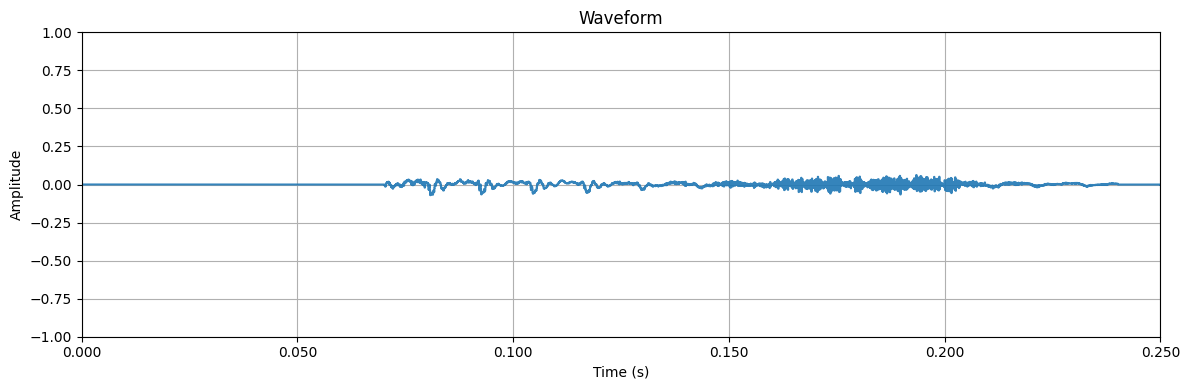

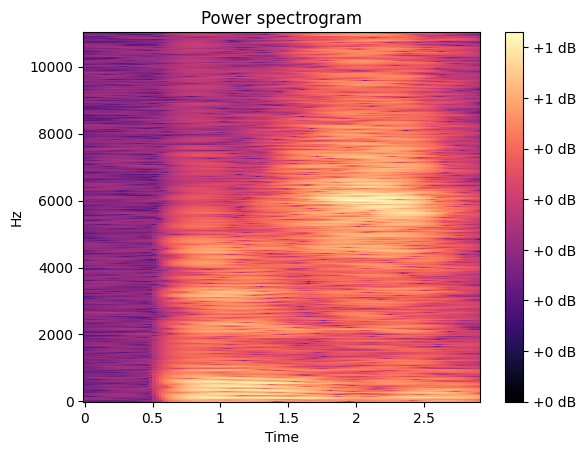

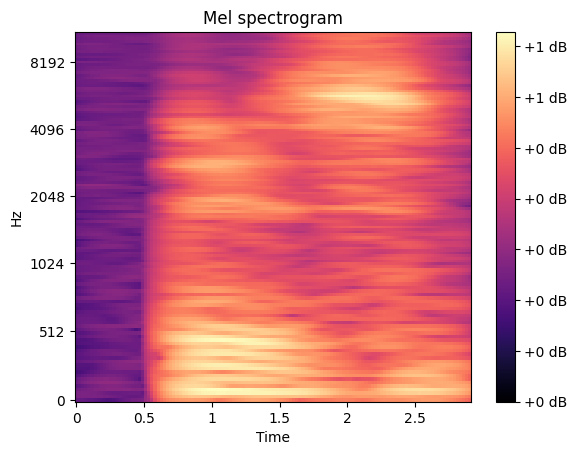

In [21]:
# this is a single process sample
sr = 16000
seed = random.randint(0,len(padded_waves))
print(test_data['word'][seed])
print(test_data['syllable'][seed])
print(test_data['stress_type'][seed])
sound = padded_waves[seed]
ap.visualize_waveform(sound,sr)
spectrogram = ap.wav_to_spectrogram(sound)
spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
ap.visualize_spectrogram(spectrogram)
mel = ap.wav_to_mel_spectrogram(sound)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_mel(mel)

In [24]:
test_data['spectrogram_path'] = test_data['suid'].apply(lambda x: os.path.join(spectrogram_folder,x+'.npy'))
dp.save_dataset(test_data,meta_path)
print(test_data['spectrogram_path'][4])
chunk_size = 5000
# Process in chunks
for start in range(0, len(padded_waves), chunk_size):
    end = min(start + chunk_size, len(padded_waves))
    chunk = padded_waves[start:end]
    pathlist = list(test_data['spectrogram_path'][start:end])
    # Convert the chunk
    chunk_spectrogram = [ap.wav_to_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB) for spectrogram in chunk_spectrogram]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk,pathlist)
    print(f'processed {end}/{len(padded_waves)}')

processed 5000/1078680
processed 10000/1078680
processed 15000/1078680
processed 20000/1078680
processed 25000/1078680
processed 30000/1078680
processed 35000/1078680
processed 40000/1078680
processed 45000/1078680
processed 50000/1078680
processed 55000/1078680
processed 60000/1078680
processed 65000/1078680
processed 70000/1078680
processed 75000/1078680
processed 80000/1078680
processed 85000/1078680
processed 90000/1078680
processed 95000/1078680
processed 100000/1078680
processed 105000/1078680
processed 110000/1078680
processed 115000/1078680
processed 120000/1078680
processed 125000/1078680
processed 130000/1078680
processed 135000/1078680
processed 140000/1078680
processed 145000/1078680
processed 150000/1078680
processed 155000/1078680
processed 160000/1078680
processed 165000/1078680
processed 170000/1078680
processed 175000/1078680
processed 180000/1078680
processed 185000/1078680
processed 190000/1078680
processed 195000/1078680
processed 200000/1078680
processed 205000/107

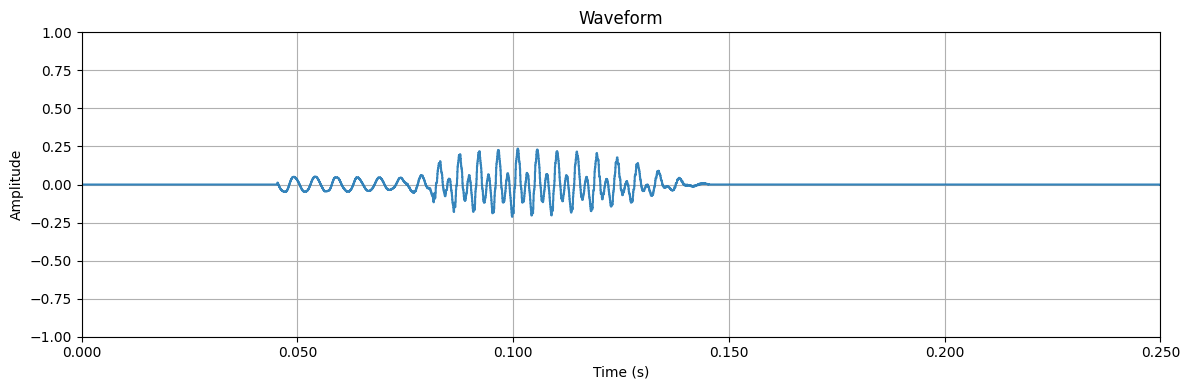

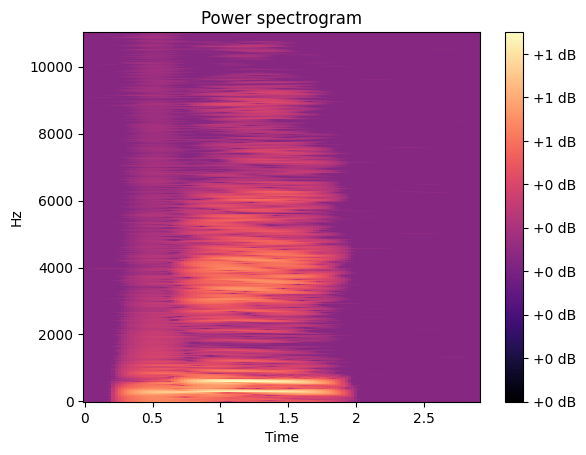

In [25]:
# check normalized data and original waveform
seed = random.randint(0,len(padded_waves))
wave = padded_waves[seed]
ap.visualize_waveform(wave,sr)
spectrogram = np.load(test_data['spectrogram_path'][seed])
ap.visualize_spectrogram(spectrogram)

In [26]:
# delete used variables after saving to free space
del chunk,normalized_chunk,chunk_spectrogram

### convert waveform to mel-spectrogram

In [ ]:
test_data['mel_path'] = test_data['suid'].apply(lambda x: os.path.join(mel_folder,x+'.npy'))
dp.save_dataset(test_data,meta_path)
print(test_data['mel_path'][4])

In [30]:
chunk_size = 5000
# Process in chunks
for start in range(0, len(padded_waves), chunk_size):
    end = min(start + chunk_size, len(padded_waves))
    chunk = padded_waves[start:end]
    pathlist = list(test_data['mel_path'][start:end])
    # Convert the chunk
    chunk_mel = [ap.wav_to_mel_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB) for mel in chunk_mel]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk,pathlist)
    print(f'processed {end}/{len(padded_waves)}')

processed 5000/1078680
processed 10000/1078680
processed 15000/1078680
processed 20000/1078680
processed 25000/1078680
processed 30000/1078680
processed 35000/1078680
processed 40000/1078680
processed 45000/1078680
processed 50000/1078680
processed 55000/1078680
processed 60000/1078680
processed 65000/1078680
processed 70000/1078680
processed 75000/1078680
processed 80000/1078680
processed 85000/1078680
processed 90000/1078680
processed 95000/1078680
processed 100000/1078680
processed 105000/1078680
processed 110000/1078680
processed 115000/1078680
processed 120000/1078680
processed 125000/1078680
processed 130000/1078680
processed 135000/1078680
processed 140000/1078680
processed 145000/1078680
processed 150000/1078680
processed 155000/1078680
processed 160000/1078680
processed 165000/1078680
processed 170000/1078680
processed 175000/1078680
processed 180000/1078680
processed 185000/1078680
processed 190000/1078680
processed 195000/1078680
processed 200000/1078680
processed 205000/107

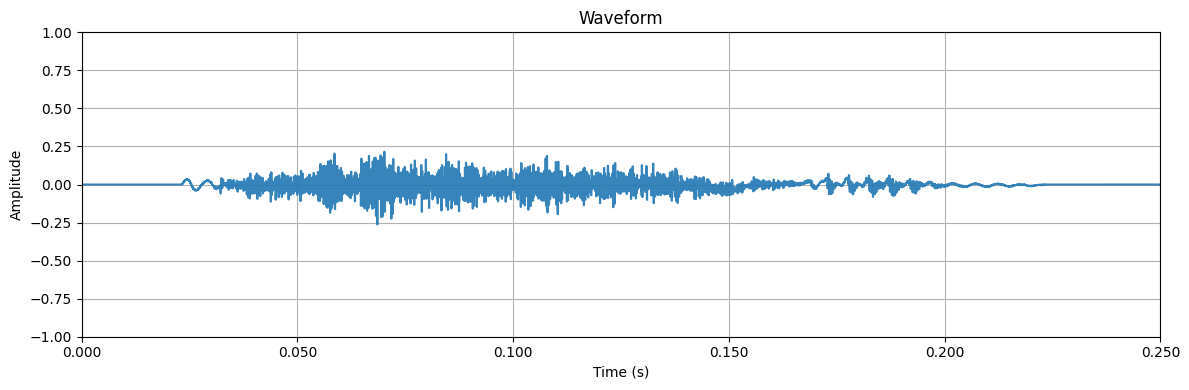

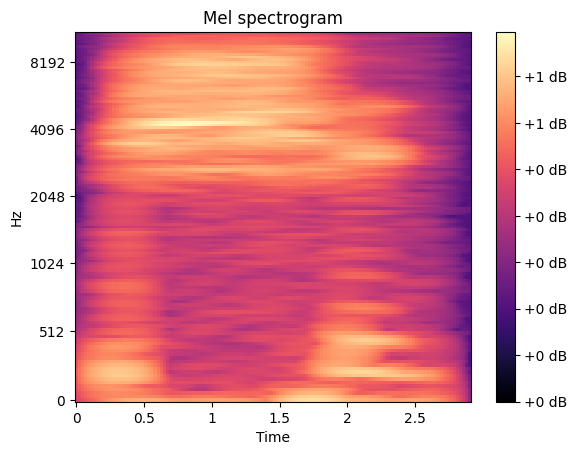

In [32]:
seed = random.randint(0,len(padded_waves))
wave = padded_waves[seed]
ap.visualize_waveform(wave,sr)
mel = np.load(test_data['mel_path'][seed])
ap.visualize_mel(mel)

In [33]:
del chunk,chunk_mel,normalized_chunk

## high/low filter

Z ER0 D


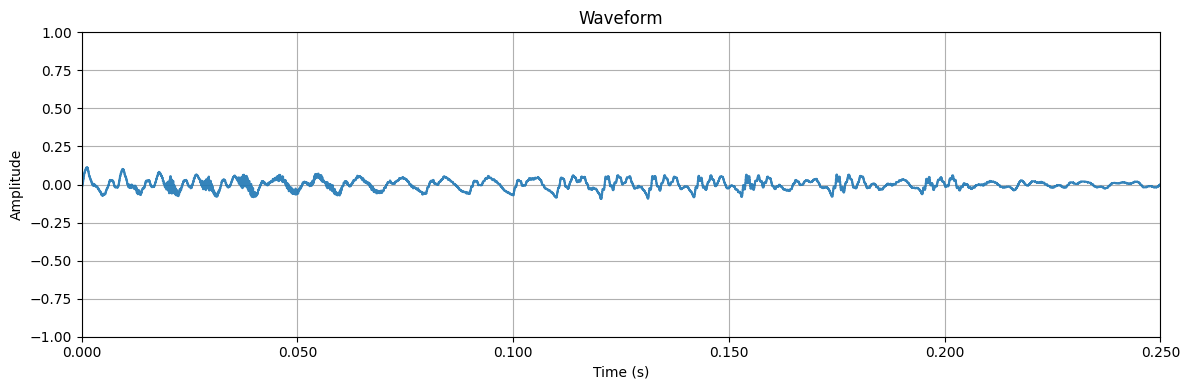

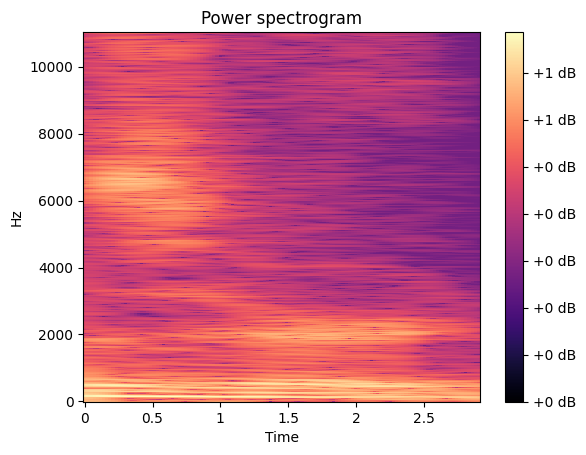

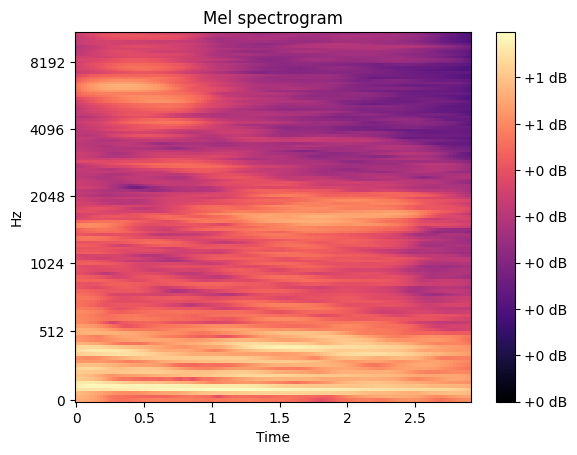

In [34]:
# get a sample
seed = random.randint(0,len(padded_waves))
print(test_data['syllable'][seed])
sound = padded_waves[seed]
ap.visualize_waveform(sound,sr)
spectrogram = ap.wav_to_spectrogram(sound)
spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
ap.visualize_spectrogram(spectrogram)
mel = ap.wav_to_mel_spectrogram(sound)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_mel(mel)

### low pass

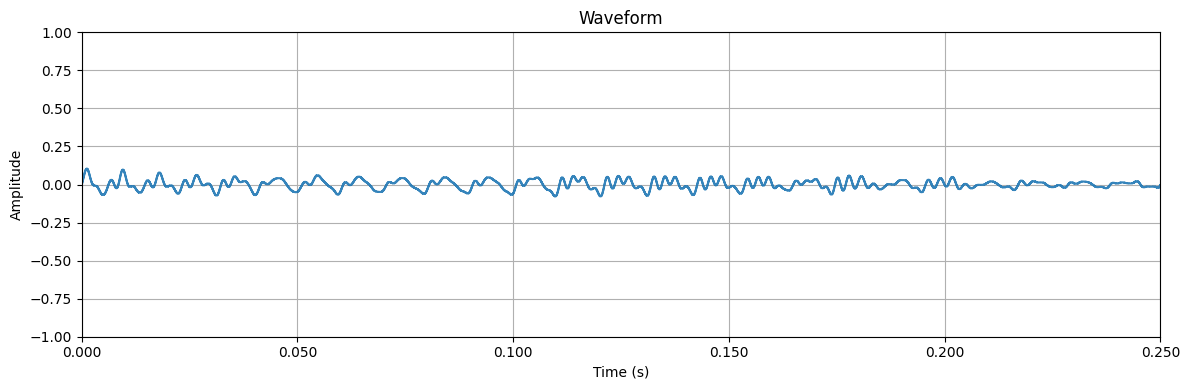

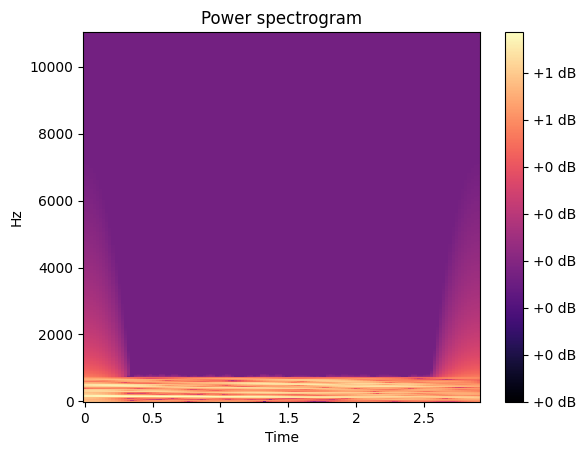

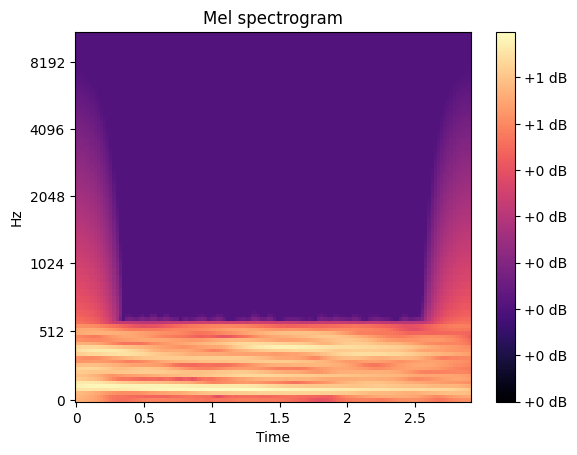

In [35]:
sound_low = ap.lowpass_filter(sound,sr,cut_off_upper=500,cut_off_lower=0)
ap.visualize_waveform(sound_low,sr)
S = ap.wav_to_spectrogram(sound_low)
S = dp.fixed_min_max_normalization(S,min = spec_min_dB, max = spec_max_dB)
mel = ap.wav_to_mel_spectrogram(sound_low,sr)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_spectrogram(S)
ap.visualize_mel(mel)

In [36]:
lowpassed = [ap.lowpass_filter(sound,sr,cut_off_upper=500,cut_off_lower=0) for sound in padded_waves]

In [37]:
# dp.save_dataset((suids,lowpassed),lowpass_waves_path) 

In [41]:
del lowpassed

#### convert to spec

In [40]:
test_data['lowpass_spectrogram_path'] = test_data['suid'].apply(lambda x: os.path.join(lowpass_spectrogram_folder, x + '.npy'))
dp.save_dataset(test_data, meta_path)
print(test_data['lowpass_spectrogram_path'][4])

/mnt/storage/compling/proslearn/src/eng/lowpass_spectrograms/1034-121119-0000-0005.npy


In [43]:
suid,lowpassed = dp.load_dataset(lowpass_waves_path)

AH0 V


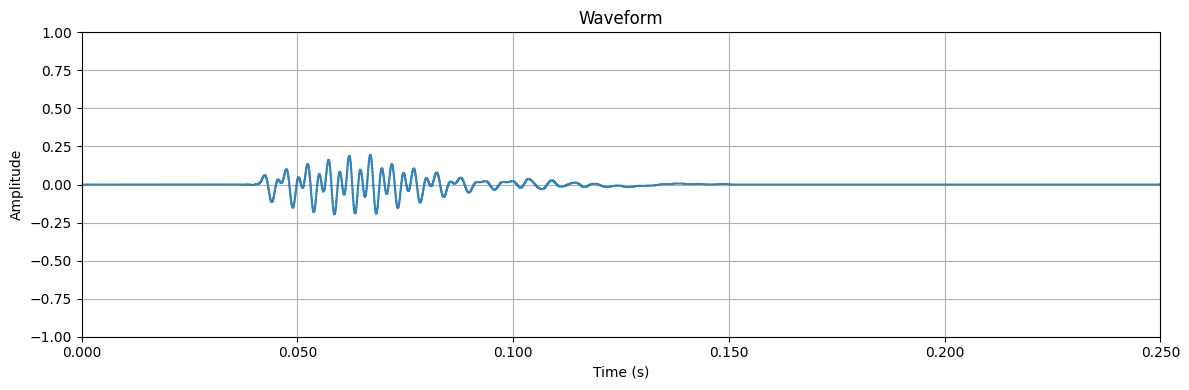

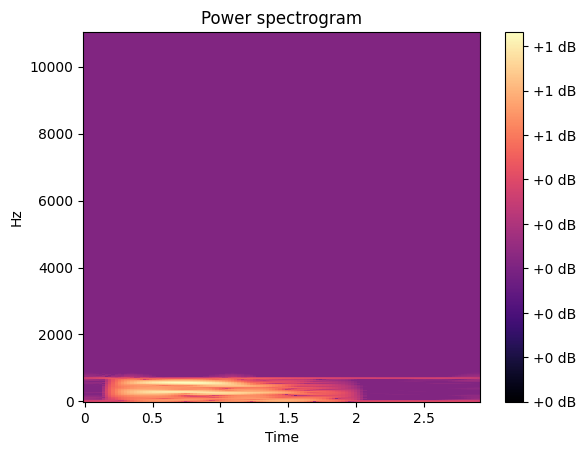

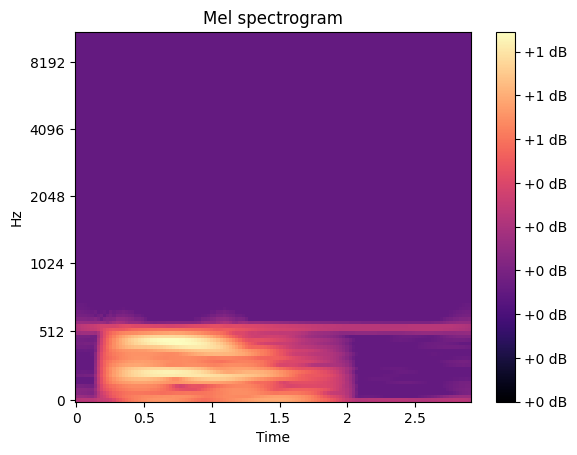

In [44]:
# get a sample
seed = random.randint(0,len(lowpassed))
print(test_data['syllable'][seed])
sound = lowpassed[seed]
ap.visualize_waveform(sound,sr)
spectrogram = ap.wav_to_spectrogram(sound)
spectrogram = dp.fixed_min_max_normalization(spectrogram,min = spec_min_dB, max = spec_max_dB)
ap.visualize_spectrogram(spectrogram)
mel = ap.wav_to_mel_spectrogram(sound)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_mel(mel)

In [45]:
chunk_size = 5000
# Process in chunks
for start in range(0, len(lowpassed), chunk_size):
    end = min(start + chunk_size, len(lowpassed))
    chunk = lowpassed[start:end]
    pathlist = list(test_data['lowpass_spectrogram_path'][start:end])
    # Convert the chunk
    chunk_spectrogram = [ap.wav_to_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(spectrogram, min=spec_min_dB, max=spec_max_dB) for spectrogram in
                        chunk_spectrogram]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk, pathlist)
    print(f'processed {end}/{len(lowpassed)}')

processed 5000/1078680
processed 10000/1078680
processed 15000/1078680
processed 20000/1078680
processed 25000/1078680
processed 30000/1078680
processed 35000/1078680
processed 40000/1078680
processed 45000/1078680
processed 50000/1078680
processed 55000/1078680
processed 60000/1078680
processed 65000/1078680
processed 70000/1078680
processed 75000/1078680
processed 80000/1078680
processed 85000/1078680
processed 90000/1078680
processed 95000/1078680
processed 100000/1078680
processed 105000/1078680
processed 110000/1078680
processed 115000/1078680
processed 120000/1078680
processed 125000/1078680
processed 130000/1078680
processed 135000/1078680
processed 140000/1078680
processed 145000/1078680
processed 150000/1078680
processed 155000/1078680
processed 160000/1078680
processed 165000/1078680
processed 170000/1078680
processed 175000/1078680
processed 180000/1078680
processed 185000/1078680
processed 190000/1078680
processed 195000/1078680
processed 200000/1078680
processed 205000/107

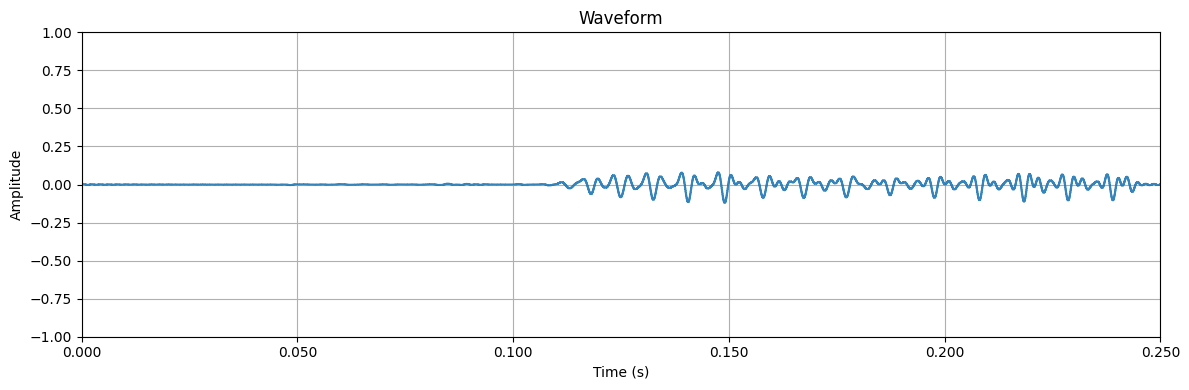

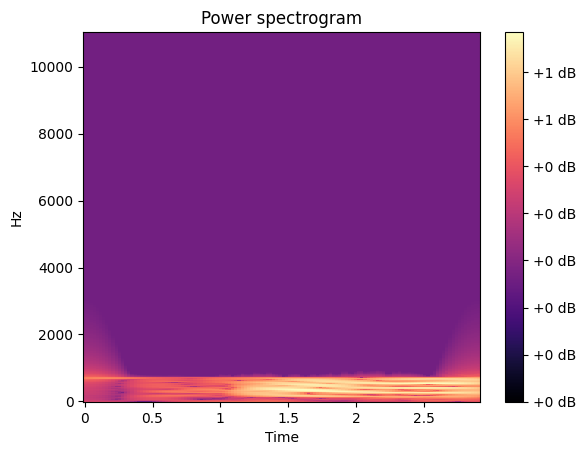

In [46]:
# check normalized data and original waveform
seed = random.randint(0,len(lowpassed))
wave = lowpassed[seed]
ap.visualize_waveform(wave,sr)
spectrogram = np.load(test_data['lowpass_spectrogram_path'][seed])
ap.visualize_spectrogram(spectrogram)

In [47]:
# delete used variables after saving to free space
del chunk,normalized_chunk,chunk_spectrogram

#### conver to mel

In [48]:
test_data['lowpass_mel_path'] = test_data['suid'].apply(lambda x: os.path.join(lowpass_mel_folder,x+'.npy'))
dp.save_dataset(test_data,meta_path)
print(test_data['lowpass_mel_path'][4])

/mnt/storage/compling/proslearn/src/eng/lowpass_mels/1034-121119-0000-0005.npy


In [ ]:
chunk_size = 5000
# Process in chunks
for start in range(0, len(lowpassed), chunk_size):
    end = min(start + chunk_size, len(lowpassed))
    chunk = lowpassed[start:end]
    pathlist = list(test_data['mel_path'][start:end])
    # Convert the chunk
    chunk_mel = [ap.wav_to_mel_spectrogram(sound) for sound in chunk]
    # Normalize the chunk
    normalized_chunk = [dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB) for mel in chunk_mel]
    # Save converted spectrograms
    dp.save_multiple_arrays(normalized_chunk,pathlist)
    print(f'processed {end}/{len(lowpassed)}')

### high pass

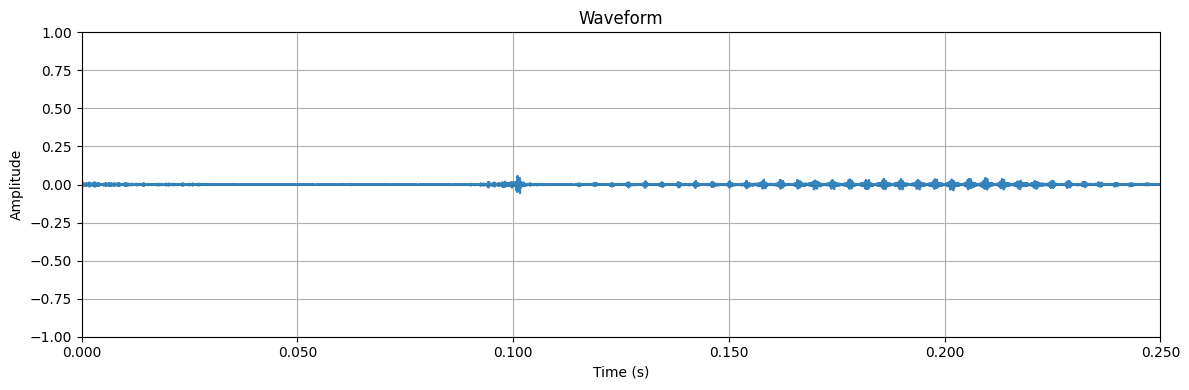

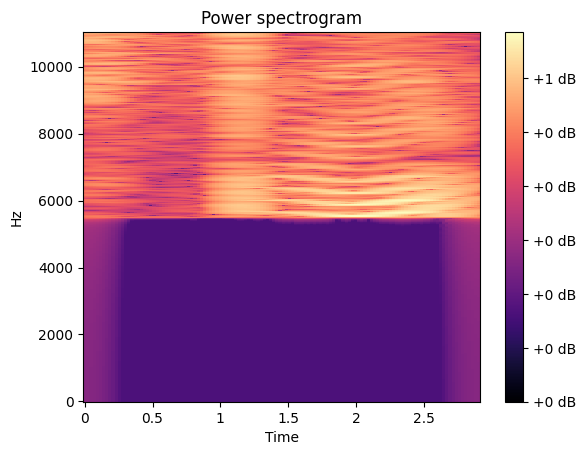

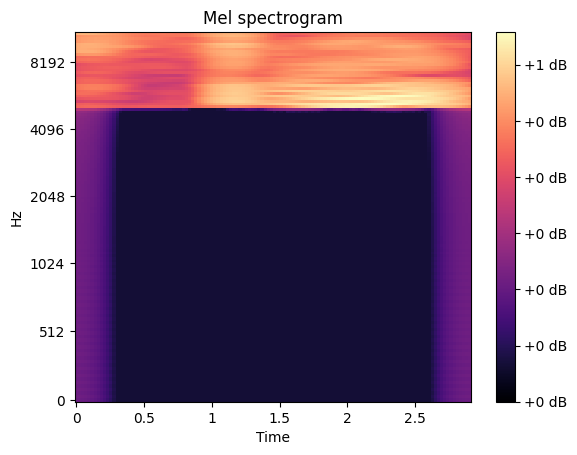

In [18]:
sound_high = ap.lowpass_filter(sound,sr,cut_off_upper=int(sr/2),cut_off_lower=4000)
ap.visualize_waveform(sound_high,sr)
S = ap.wav_to_spectrogram(sound_high)
S= dp.fixed_min_max_normalization(S,min = spec_min_dB, max = spec_max_dB)
mel = ap.wav_to_mel_spectrogram(sound_high)
mel = dp.fixed_min_max_normalization(mel,min = mel_min_dB, max = mel_max_dB)
ap.visualize_spectrogram(S)
ap.visualize_mel(mel)

In [38]:
highpassed = [ap.lowpass_filter(sound,sr,cut_off_upper=int(sr/2),cut_off_lower=4000) for sound in padded_waves]

In [39]:
dp.save_dataset((suids,highpassed),highpass_waves_path)

In [42]:
del highpassed